# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Разбор задачи

По фотографии нужно определить возраст человека. То есть число в ответе — это количество лет. Следовательно, это задача регрессии. В конце нейронной сети должен остаться только один нейрон, который и вернет число-предсказание. В качестве активации для него необходимо выбрать ReLU, потому что положительные прогнозы сети функция ReLU не меняет, а все отрицательные приводит к нулю (в нашей задаче чисел меньше 0 быть не может). В качестве метрики качества выберем MAE.

План решения задачи:  
1. Провести исследовательский анализ набора данных.  
2. Обучить модель (в GPU-тренажере Yandex.Practicum).
3. Сохранить результат обучения модели и проанализировать его.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/). В учебном проекте они находятся в папке */datasets/faces/*: папка */final_files* содержит все файлы изображений, а разметка содержится в файле *labels.csv*.

In [ ]:
# Определение размера изображения, размера выборки и пути  к набору даных
IMAGE_SIZE=224
BATCH_SIZE=32
PATH='/datasets/faces/'

In [ ]:
# загружаем разметку
labels = pd.read_csv(os.path.join(PATH, 'labels.csv'))

# создаем загрузчик данных
train_datagen = ImageDataGenerator(rescale=1./255)

# извлекаем данные
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(PATH, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Загрузчик нашел 7591 изображение. Выборка относительно небольшая, но при необходимости мы сможем нарастить ее, применяя аугментации.

In [ ]:
# Получаем пару "картинки - метки"
features, target = next(train_gen_flow)
print(features.shape)

(32, 224, 224, 3)


Получились признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

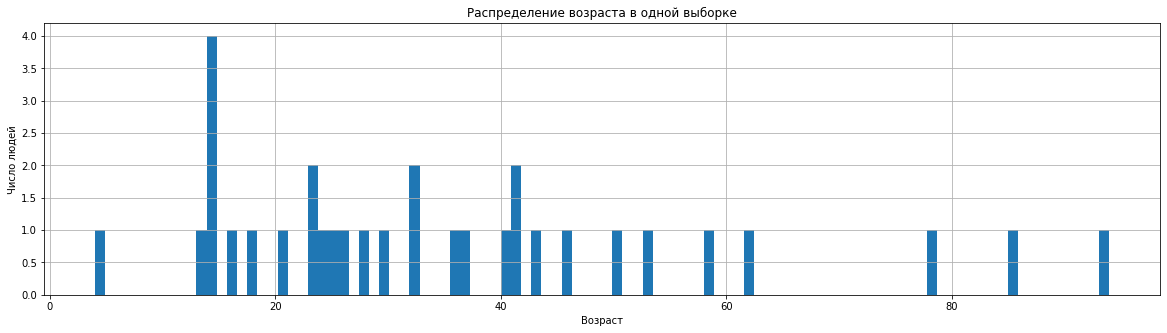

In [ ]:
# Строим гистограмму распределения возраста в полученной выборке
plt.figure(figsize=(20, 5))
plt.xlabel('Возраст')
plt.ylabel('Число людей')
plt.title('Распределение возраста в одной выборке')
plt.grid(True)
plt.hist(target, bins=100)
plt.show();

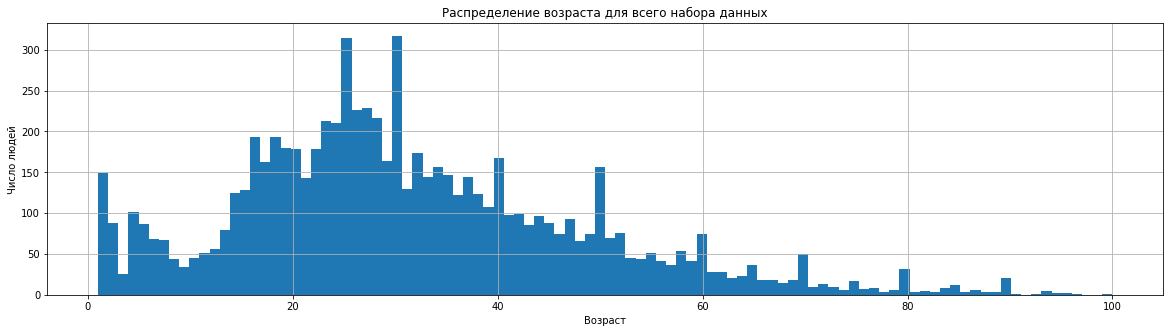

In [ ]:
# Строим гистограмму распределения возраста в полученной выборке
plt.figure(figsize=(20, 5))
plt.xlabel('Возраст')
plt.ylabel('Число людей')
plt.title('Распределение возраста для всего набора данных')
plt.grid(True)
plt.hist(labels.real_age, bins=100)
plt.show();

In [ ]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Анализируя гистограмму целевого признака, обращаем внимание на пики в районе "юбилейных" лет. Они могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его. Поэтому некоторые "круглые" года в датасете могут быть некорректными.

1) Возраст: 50


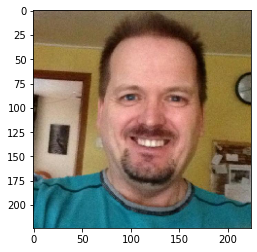

2) Возраст: 41


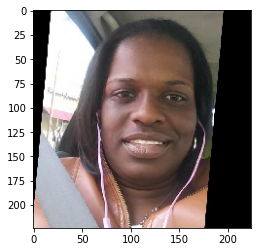

3) Возраст: 46


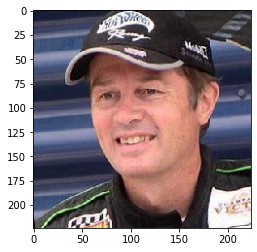

4) Возраст: 85


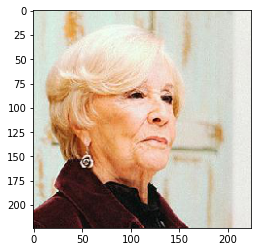

5) Возраст: 14


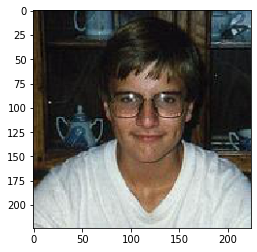

6) Возраст: 40


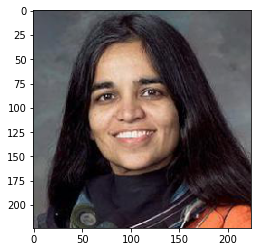

7) Возраст: 14


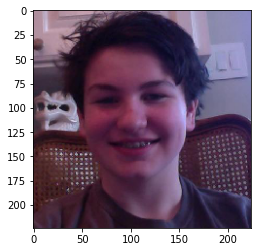

8) Возраст: 53


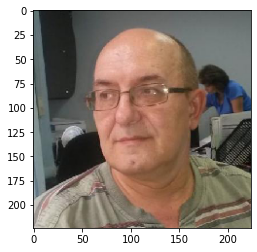

9) Возраст: 4


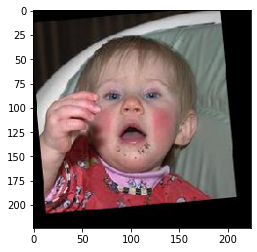

10) Возраст: 32


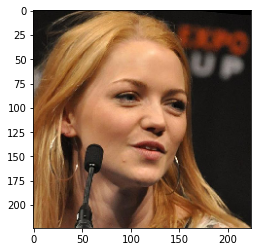

In [ ]:
# Печатаем 10 фотографий
for i in range(10):
    print(f'{i+1}) Возраст:', target[i])
    plt.imshow(features[i]);
    plt.show()

In [ ]:
# Проверяем данные на наличие пропусков
labels.isna().any()

file_name    False
real_age     False
dtype: bool

In [ ]:
# Проверяем данные на дубликаты
labels.duplicated().any()

False

**Выводы.**  
Мы провели исследование входных данных. У нас имеется одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Мы создали загрузчик данных, который формирует батчи по 32 изображения размером 224х224. Загрузчик нашел 7591 изображение. Проанализировав распределение возраста в батче и во всем наборе данных, можно сказать, что возраст распределен нормально с пиком в районе 30 лет. Минимум - 1 год, максимум - 100 лет. Мы просмотрели несколько фотографий - можно сказать, что указанный возраст соответствует фотографиям.

Общая ориентация фотографий примерно одинакова: в некоторых фото их уже повернули за нас, чтобы выровнять положение лица. Следовательно, нам их не обязательно поворачивать. Начальный размер изображений отличается из-за того, что визуально заметно различное качество фото. Где-то есть черные рамки (они не несут полезной информации). В итоге, перед обучением модели размер изображений нужно привести к единому.

Данные не содержат пропусков или дубликатов.

В результате анализа можно сказать, что данные непротиворечивы и репрезентативны и их можно использовать для обучения модели.

## Обучение модели

### Код обучения модели

Обучение модели выполнялось в GPU-тренажере Yandex.Practicum.

Будем использовать архитектуру **ResNet50**, предобученную на датасете *ImageNet*. Два последних слоя: *GlobalAveragePooling2D* усредняет информацию по всему изображению, *Dense* является полносвязным слоем для классификации. Для оптимизации обучения будем использовать алгоритм Adam с параметром *learning rate=0.0001*. На выходе один нейрон с активацией ReLU.

```python

import os
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50

# Определяем размер изображения и размер выборки
IMAGE_SIZE=224
BATCH_SIZE=32

# Функция загрузки обучающих данных
def load_train(path):
    path_labels = os.path.join(path, "labels.csv")
    path_img_dir = os.path.join(path, "final_files")
    df_labels = pd.read_csv(path_labels)
    datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25)
    train_generator = datagen.flow_from_dataframe(
                        df_labels,
                        x_col="file_name", y_col="real_age",
                        directory=path_img_dir, 
                        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                        batch_size=BATCH_SIZE,  
                        class_mode='raw',
                        subset='training',
                        seed=12345)
    return train_generator

# Функция загрузки тестовых данных
def load_test(path):
    path_labels = os.path.join(path, "labels.csv")
    path_img_dir = os.path.join(path, "final_files")
    df_labels = pd.read_csv(path_labels)
    datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25)
    test_generator = datagen.flow_from_dataframe(
                        df_labels,
                        x_col="file_name", y_col="real_age",
                        directory=path_img_dir, 
                        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                        batch_size=BATCH_SIZE,  
                        class_mode='raw',
                        subset='validation',
                        seed=12345)
    return test_generator

# Функция создания модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                      weights='imagenet', 
                      include_top=False)
    
    optimizer = Adam(lr=0.0001)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    
    return model

# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

### Результат вывода на экран

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 68s - loss: 245.8404 - mean_absolute_error: 11.2085 - val_loss: 662.2145 - val_mean_absolute_error: 20.7811
Epoch 2/10
178/178 - 38s - loss: 60.6743 - mean_absolute_error: 5.8712 - val_loss: 754.2990 - val_mean_absolute_error: 22.4968
Epoch 3/10
178/178 - 38s - loss: 29.7234 - mean_absolute_error: 4.1999 - val_loss: 308.6769 - val_mean_absolute_error: 13.0208
Epoch 4/10
178/178 - 37s - loss: 18.9765 - mean_absolute_error: 3.3683 - val_loss: 115.5261 - val_mean_absolute_error: 8.1494
Epoch 5/10
178/178 - 38s - loss: 14.7903 - mean_absolute_error: 2.9758 - val_loss: 80.9836 - val_mean_absolute_error: 6.9154
Epoch 6/10
178/178 - 37s - loss: 12.3106 - mean_absolute_error: 2.6980 - val_loss: 76.7851 - val_mean_absolute_error: 6.6049
Epoch 7/10
178/178 - 37s - loss: 9.6896 - mean_absolute_error: 2.3721 - val_loss: 67.1257 - val_mean_absolute_error: 6.2295
Epoch 8/10
178/178 - 37s - loss: 8.7243 - mean_absolute_error: 2.2333 - val_loss: 70.7001 - val_mean_absolute_error: 6.6341
Epoch 9/10
178/178 - 37s - loss: 8.2302 - mean_absolute_error: 2.1555 - val_loss: 81.7734 - val_mean_absolute_error: 6.9134
Epoch 10/10
178/178 - 37s - loss: 7.5207 - mean_absolute_error: 2.0785 - val_loss: 66.0551 - val_mean_absolute_error: 6.2025
60/60 - 9s - loss: 66.0551 - mean_absolute_error: 6.2025
Test MAE: 6.2025

```

## Анализ обученной модели

Мы построили модель, предсказывающую возраст по фотографии со средней абсолютной ошибкой MAE = 6.2025. 

Исходные данные разделили на обучающую и тестовую выборку (75/25). Модель регрессии обучалась на 10 эпохах, результатом было одно число — количество лет. Мы воспользовались сетью *ResNet50*, предобученной на датасете *ImageNet*. Применили алгортм Adam для настройки скорости обучения. На выходе — один нейрон с активацией ReLU. В качестве фукции потерь использовалась MSE. По условию задачи мы должны были получить MAE меньше 8. Мы получили 6.2025, поэтому можем счтать, что построенную модель можно использовать для решения поставленной задачи.